In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import wandb

import warnings
warnings.filterwarnings("ignore")

{'TailStartEpoch': 119.2, 'MaxEpoch': 149.0, 'n_tail_rows': 30, 'Var_G': 0.031299224335903285, 'Var_D': 0.12141745888765404, 'Drift_G': 0.0014662793748958028, 'Drift_D': 0.013749540930134271}


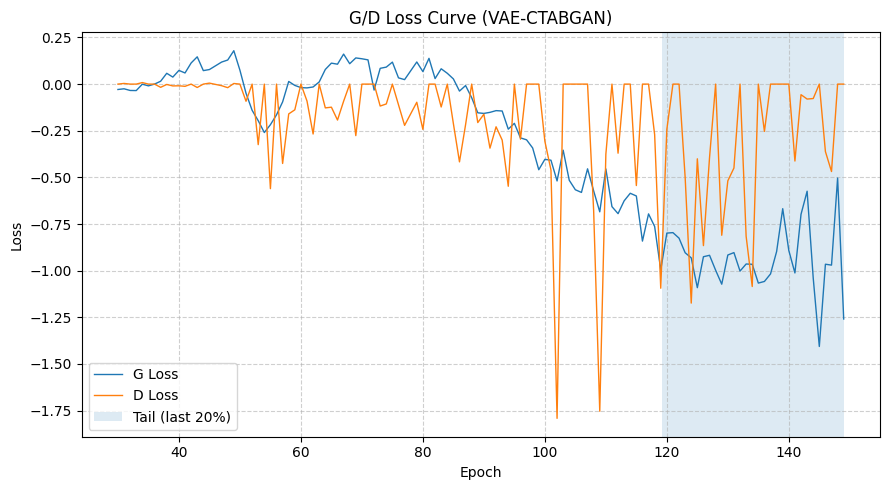

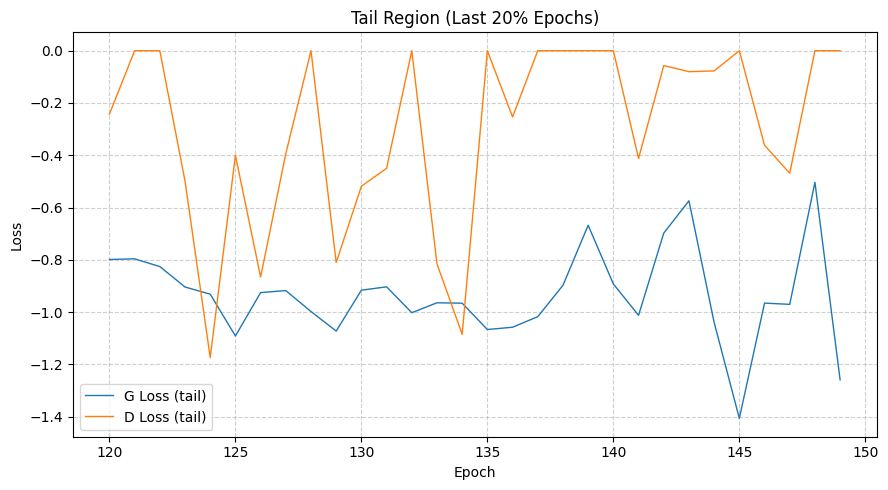

In [2]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ====== 유틸 ======
def group_by_epoch(hist, g_key="g_loss", d_key="d_loss"):
    """step 단위 로그를 epoch별 평균으로 집계"""
    return (hist[["epoch", g_key, d_key]]
            .dropna()
            .groupby("epoch", as_index=False)
            .mean()
            .sort_values("epoch"))

def get_tail_epoch_df(df_epoch, frac=0.2):
    """epoch 기준 마지막 frac 구간만 필터링"""
    max_ep = df_epoch["epoch"].max()
    tail_start = max_ep * (1 - frac)
    tail = df_epoch[df_epoch["epoch"] >= tail_start].copy()
    return tail, tail_start, max_ep

def drift_slope(y):
    """마지막 구간에서의 추세(절댓값 기울기). 인덱스 기준으로 회귀"""
    X = np.arange(len(y)).reshape(-1, 1)
    lr = LinearRegression().fit(X, y)
    return float(abs(lr.coef_[0]))

def stability_metrics_epoch(df_epoch, g_key="g_loss", d_key="d_loss", tail_frac=0.2):
    """epoch별 집계 데이터프레임에서 tail 안정성 지표 계산"""
    tail, tail_start, max_ep = get_tail_epoch_df(df_epoch, frac=tail_frac)
    y_g = tail[g_key].values
    y_d = tail[d_key].values
    out = {
        "TailStartEpoch": float(tail_start),
        "MaxEpoch": float(max_ep),
        "n_tail_rows": int(len(tail)),      # tail 구간의 epoch 개수(예: 150ep면 ~30개)
        "Var_G": float(np.var(y_g)),
        "Var_D": float(np.var(y_d)),
        "Drift_G": drift_slope(y_g),
        "Drift_D": drift_slope(y_d),
    }
    return out, tail

# ====== 실행 ======
api = wandb.Api()
run = api.run("empe8339-gachon-university/vae-ctab-gan/e7hw8vvt")

# 네가 기록한 키 이름에 맞춰주세요 (예: "train/g_loss" 등)
hist = run.history(keys=["epoch", "g_loss", "d_loss"], pandas=True)

# 1) epoch별 평균으로 정리
df_epoch = group_by_epoch(hist, g_key="g_loss", d_key="d_loss")

# 2) tail(마지막 20% epoch) 기준 안정성 지표
metrics, tail = stability_metrics_epoch(df_epoch, g_key="g_loss", d_key="d_loss", tail_frac=0.2)
print(metrics)

# 3) 전체 및 tail 하이라이트 플롯
plt.figure(figsize=(9,5))
plt.plot(df_epoch["epoch"], df_epoch["g_loss"], label="G Loss", linewidth=1)
plt.plot(df_epoch["epoch"], df_epoch["d_loss"], label="D Loss", linewidth=1)

# tail 구간 음영 표시
plt.axvspan(metrics["TailStartEpoch"], metrics["MaxEpoch"], alpha=0.15, label="Tail (last 20%)")

plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("G/D Loss Curve (VAE-CTABGAN)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

# 4) tail만 확대 보기(선택)
plt.figure(figsize=(9,5))
plt.plot(tail["epoch"], tail["g_loss"], label="G Loss (tail)", linewidth=1)
plt.plot(tail["epoch"], tail["d_loss"], label="D Loss (tail)", linewidth=1)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Tail Region (Last 20% Epochs)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()


{'TailStartEpoch': 239.20000000000002, 'MaxEpoch': 299.0, 'n_tail_rows': 60, 'Var_G': 4.240402768479616, 'Var_D': 0.0003101445678009184, 'Drift_G': 0.03883566150204215, 'Drift_D': 0.0002632712051337329}


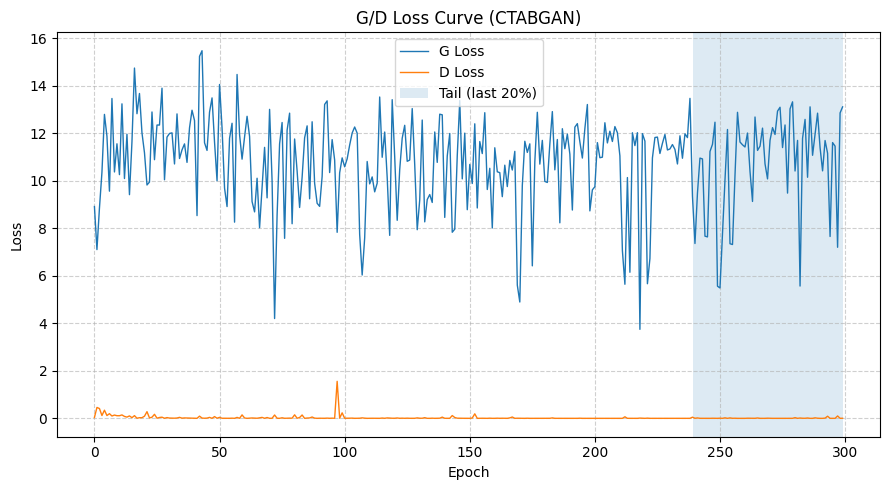

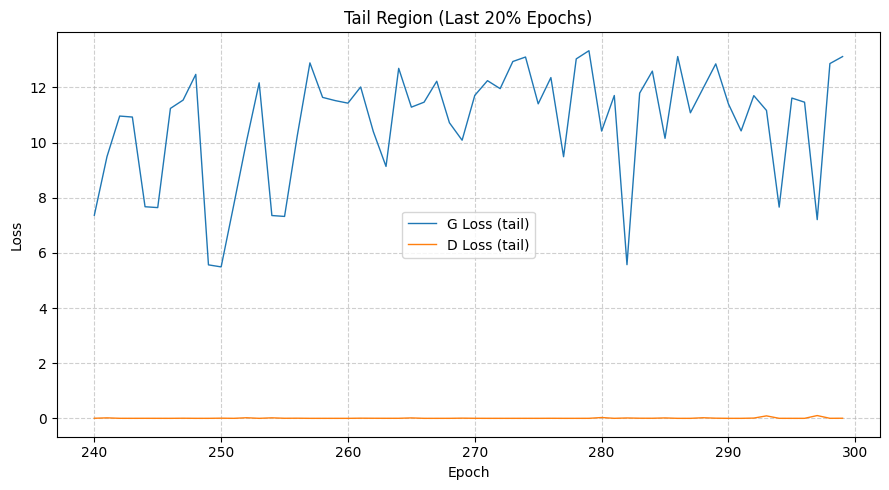

In [3]:
## CTABGAN
def group_by_epoch(hist, g_key="g_loss", d_key="d_loss"):
    """step 단위 로그를 epoch별 평균으로 집계"""
    return (hist[["epoch", g_key, d_key]]
            .dropna()
            .groupby("epoch", as_index=False)
            .mean()
            .sort_values("epoch"))

def get_tail_epoch_df(df_epoch, frac=0.2):
    """epoch 기준 마지막 frac 구간만 필터링"""
    max_ep = df_epoch["epoch"].max()
    tail_start = max_ep * (1 - frac)
    tail = df_epoch[df_epoch["epoch"] >= tail_start].copy()
    return tail, tail_start, max_ep

def drift_slope(y):
    """마지막 구간에서의 추세(절댓값 기울기). 인덱스 기준으로 회귀"""
    X = np.arange(len(y)).reshape(-1, 1)
    lr = LinearRegression().fit(X, y)
    return float(abs(lr.coef_[0]))

def stability_metrics_epoch(df_epoch, g_key="g_loss", d_key="d_loss", tail_frac=0.2):
    """epoch별 집계 데이터프레임에서 tail 안정성 지표 계산"""
    tail, tail_start, max_ep = get_tail_epoch_df(df_epoch, frac=tail_frac)
    y_g = tail[g_key].values
    y_d = tail[d_key].values
    out = {
        "TailStartEpoch": float(tail_start),
        "MaxEpoch": float(max_ep),
        "n_tail_rows": int(len(tail)),      # tail 구간의 epoch 개수(예: 150ep면 ~30개)
        "Var_G": float(np.var(y_g)),
        "Var_D": float(np.var(y_d)),
        "Drift_G": drift_slope(y_g),
        "Drift_D": drift_slope(y_d),
    }
    return out, tail

## CTAB-GAN
api2 = wandb.Api()
run2 = api2.run("empe8339-gachon-university/CTABGAN/0l2149l6")
hist2 = run2.history(keys=["epoch","loss_g","loss_d"], pandas=True)

df_epoch = group_by_epoch(hist2, g_key="loss_g", d_key="loss_d")

# 2) tail(마지막 20% epoch) 기준 안정성 지표
metrics, tail = stability_metrics_epoch(df_epoch, g_key="loss_g", d_key="loss_d", tail_frac=0.2)
print(metrics)

# 3) 전체 및 tail 하이라이트 플롯
plt.figure(figsize=(9,5))
plt.plot(df_epoch["epoch"], df_epoch["loss_g"], label="G Loss", linewidth=1)
plt.plot(df_epoch["epoch"], df_epoch["loss_d"], label="D Loss", linewidth=1)

# tail 구간 음영 표시
plt.axvspan(metrics["TailStartEpoch"], metrics["MaxEpoch"], alpha=0.15, label="Tail (last 20%)")

plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("G/D Loss Curve (CTABGAN)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

# 4) tail만 확대 보기(선택)
plt.figure(figsize=(9,5))
plt.plot(tail["epoch"], tail["loss_g"], label="G Loss (tail)", linewidth=1)
plt.plot(tail["epoch"], tail["loss_d"], label="D Loss (tail)", linewidth=1)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Tail Region (Last 20% Epochs)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

{'TailStartEpoch': 239.20000000000002, 'MaxEpoch': 299.0, 'n_tail_rows': 60, 'Var_G': 0.048754028345135265, 'Var_D': 0.09136948301680607, 'Drift_G': 0.003756010712691897, 'Drift_D': 0.003749013679512478}


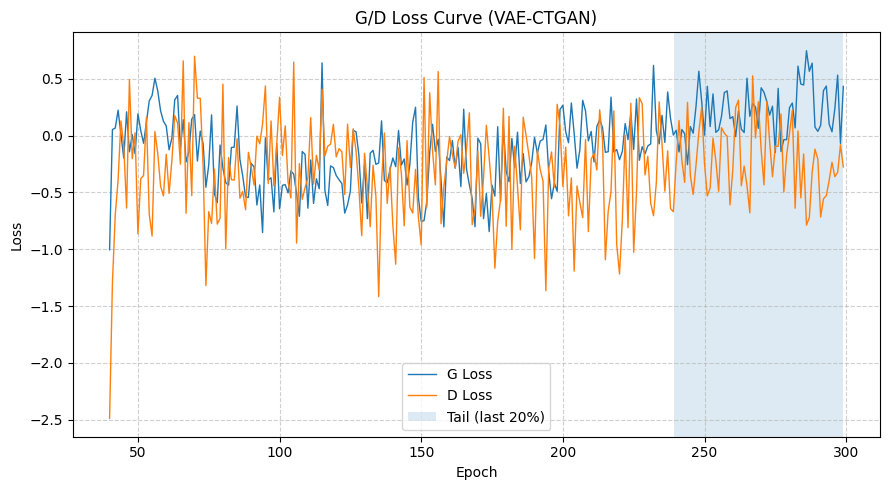

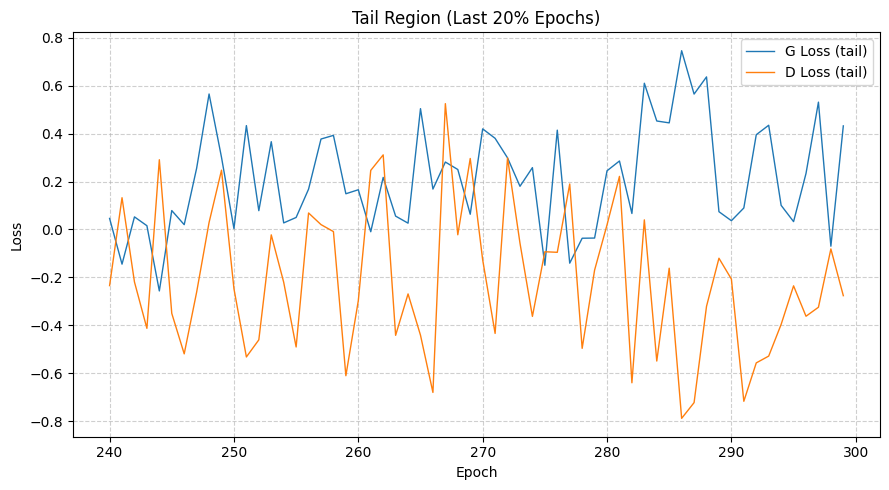

In [7]:
## VAE-CTGAN
def group_by_epoch(hist, g_key="g_loss", d_key="d_loss"):
    """step 단위 로그를 epoch별 평균으로 집계"""
    return (hist[["epoch", g_key, d_key]]
            .dropna()
            .groupby("epoch", as_index=False)
            .mean()
            .sort_values("epoch"))

def get_tail_epoch_df(df_epoch, frac=0.2):
    """epoch 기준 마지막 frac 구간만 필터링"""
    max_ep = df_epoch["epoch"].max()
    tail_start = max_ep * (1 - frac)
    tail = df_epoch[df_epoch["epoch"] >= tail_start].copy()
    return tail, tail_start, max_ep

def drift_slope(y):
    """마지막 구간에서의 추세(절댓값 기울기). 인덱스 기준으로 회귀"""
    X = np.arange(len(y)).reshape(-1, 1)
    lr = LinearRegression().fit(X, y)
    return float(abs(lr.coef_[0]))

def stability_metrics_epoch(df_epoch, g_key="g_loss", d_key="d_loss", tail_frac=0.2):
    """epoch별 집계 데이터프레임에서 tail 안정성 지표 계산"""
    tail, tail_start, max_ep = get_tail_epoch_df(df_epoch, frac=tail_frac)
    y_g = tail[g_key].values
    y_d = tail[d_key].values
    out = {
        "TailStartEpoch": float(tail_start),
        "MaxEpoch": float(max_ep),
        "n_tail_rows": int(len(tail)),      # tail 구간의 epoch 개수(예: 150ep면 ~30개)
        "Var_G": float(np.var(y_g)),
        "Var_D": float(np.var(y_d)),
        "Drift_G": drift_slope(y_g),
        "Drift_D": drift_slope(y_d),
    }
    return out, tail

## VAE-CTGAN
api2 = wandb.Api()
run2 = api2.run("empe8339-gachon-university/vae-ctgan/mk0t8c0g")
hist2 = run2.history(keys=["epoch","G_loss","D_loss"], pandas=True)

df_epoch = group_by_epoch(hist2, g_key="G_loss", d_key="D_loss")

# 2) tail(마지막 20% epoch) 기준 안정성 지표
metrics, tail = stability_metrics_epoch(df_epoch, g_key="G_loss", d_key="D_loss", tail_frac=0.2)
print(metrics)

# 3) 전체 및 tail 하이라이트 플롯
plt.figure(figsize=(9,5))
plt.plot(df_epoch["epoch"], df_epoch["G_loss"], label="G Loss", linewidth=1)
plt.plot(df_epoch["epoch"], df_epoch["D_loss"], label="D Loss", linewidth=1)

# tail 구간 음영 표시
plt.axvspan(metrics["TailStartEpoch"], metrics["MaxEpoch"], alpha=0.15, label="Tail (last 20%)")

plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("G/D Loss Curve (VAE-CTGAN)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

# 4) tail만 확대 보기(선택)
plt.figure(figsize=(9,5))
plt.plot(tail["epoch"], tail["G_loss"], label="G Loss (tail)", linewidth=1)
plt.plot(tail["epoch"], tail["D_loss"], label="D Loss (tail)", linewidth=1)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Tail Region (Last 20% Epochs)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

{'TailStartEpoch': 159.20000000000002, 'MaxEpoch': 199.0, 'n_tail_rows': 40, 'Var_G': 0.18074065970081019, 'Var_D': 0.0001935229203066041, 'Drift_G': 0.03653979849012365, 'Drift_D': 0.0011462351247682801}


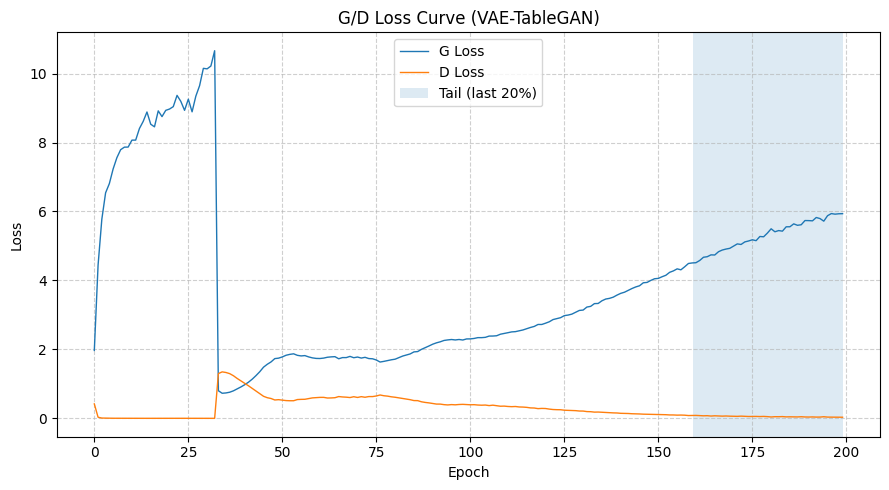

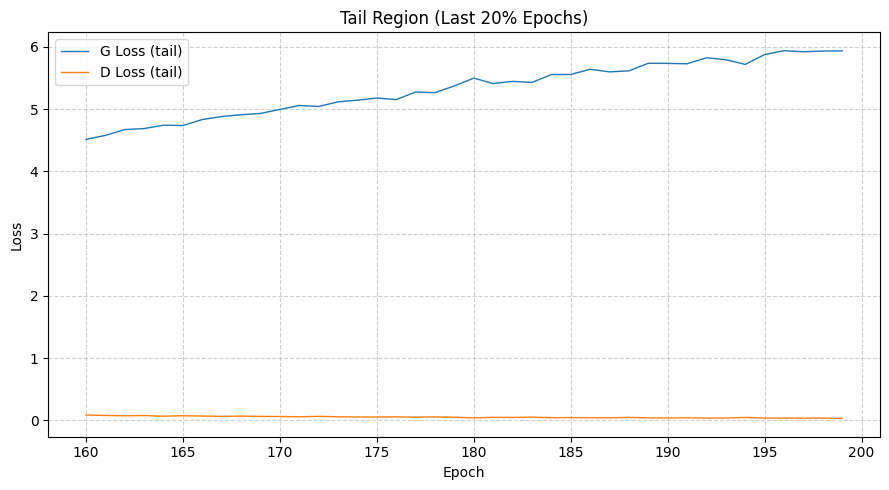

In [8]:
import wandb
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

## VAE-TAbleGAN
# ===== 기본 설정 =====
TOTAL_EPOCHS = 200  # 너가 알려준 총 에폭

def attach_epoch(df: pd.DataFrame, total_epochs=TOTAL_EPOCHS, step_col="_step"):
    """
    W&B history에 epoch이 없을 때 epoch 인덱스를 복원.
    - step 컬럼이 있으면 step 기반으로,
    - 없으면 row 인덱스 기반으로 균등 매핑.
    """
    df = df.copy().reset_index(drop=True)

    if step_col in df.columns:
        max_step = df[step_col].max()
        steps_per_epoch = max_step / total_epochs if total_epochs > 0 else max_step
        df["epoch"] = np.floor(df[step_col] / max_step * (total_epochs - 1))
    else:
        n = len(df)
        steps_per_epoch = n / total_epochs if total_epochs > 0 else n
        df["epoch"] = np.floor(np.arange(n) / steps_per_epoch)

    # 0~(E-1) 범위 보장
    df["epoch"] = df["epoch"].clip(lower=0, upper=total_epochs - 1).astype(int)
    return df

def group_by_epoch(hist, g_key, d_key):
    """epoch별 평균으로 집계"""
    return (hist[["epoch", g_key, d_key]]
            .dropna()
            .groupby("epoch", as_index=False)
            .mean()
            .sort_values("epoch"))

def get_tail_epoch_df(df_epoch, frac=0.2):
    """epoch 기준 마지막 frac 구간만 필터링 (예: 200 epoch면 마지막 40 epoch)"""
    max_ep = int(df_epoch["epoch"].max())
    tail_start = max_ep * (1 - frac)
    tail = df_epoch[df_epoch["epoch"] >= tail_start].copy()
    return tail, float(tail_start), float(max_ep)

def drift_slope(y):
    """마지막 구간 추세(절댓값 기울기)"""
    X = np.arange(len(y)).reshape(-1, 1)
    lr = LinearRegression().fit(X, y)
    return float(abs(lr.coef_[0]))

def stability_metrics_epoch(df_epoch, g_key, d_key, tail_frac=0.2):
    tail, tail_start, max_ep = get_tail_epoch_df(df_epoch, frac=tail_frac)
    y_g, y_d = tail[g_key].values, tail[d_key].values
    return {
        "TailStartEpoch": tail_start,
        "MaxEpoch": max_ep,
        "n_tail_rows": int(len(tail)),   # tail에 포함된 epoch 개수 (200이면 보통 ~40)
        "Var_G": float(np.var(y_g)),
        "Var_D": float(np.var(y_d)),
        "Drift_G": drift_slope(y_g),
        "Drift_D": drift_slope(y_d),
    }, tail

# ====== VAE-TableGAN (예시 run) ======
api = wandb.Api()
run = api.run("empe8339-gachon-university/vae-tablegan/4f74r6rg")

# epoch이 없으니 step 없이도 가능: keys에 _step이 없으면 자동으로 row기반 epoch 복원
hist = run.history(keys=["_step","advcls_loss","d_loss"], pandas=True)  # _step이 없으면 삭제해도 됨
hist = attach_epoch(hist, total_epochs=TOTAL_EPOCHS, step_col="_step")

df_epoch = group_by_epoch(hist, g_key="advcls_loss", d_key="d_loss")
metrics, tail = stability_metrics_epoch(df_epoch, g_key="advcls_loss", d_key="d_loss", tail_frac=0.2)
print(metrics)

# 3) 전체 및 tail 하이라이트 플롯
plt.figure(figsize=(9,5))
plt.plot(df_epoch["epoch"], df_epoch["advcls_loss"], label="G Loss", linewidth=1)
plt.plot(df_epoch["epoch"], df_epoch["d_loss"], label="D Loss", linewidth=1)

# tail 구간 음영 표시
plt.axvspan(metrics["TailStartEpoch"], metrics["MaxEpoch"], alpha=0.15, label="Tail (last 20%)")

plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("G/D Loss Curve (VAE-TableGAN)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()

# 4) tail만 확대 보기(선택)
plt.figure(figsize=(9,5))
plt.plot(tail["epoch"], tail["advcls_loss"], label="G Loss (tail)", linewidth=1)
plt.plot(tail["epoch"], tail["d_loss"], label="D Loss (tail)", linewidth=1)
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Tail Region (Last 20% Epochs)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout(); plt.show()


{'TailStartEpoch': 346.40000000000003, 'MaxEpoch': 433.0, 'n_tail_epochs': 87, 'Var_G': 0.005685856749342944, 'Var_D': 0.00011652536727983267, 'Drift_G': 0.0022475955265364323, 'Drift_D': 4.2416726798867606e-06}


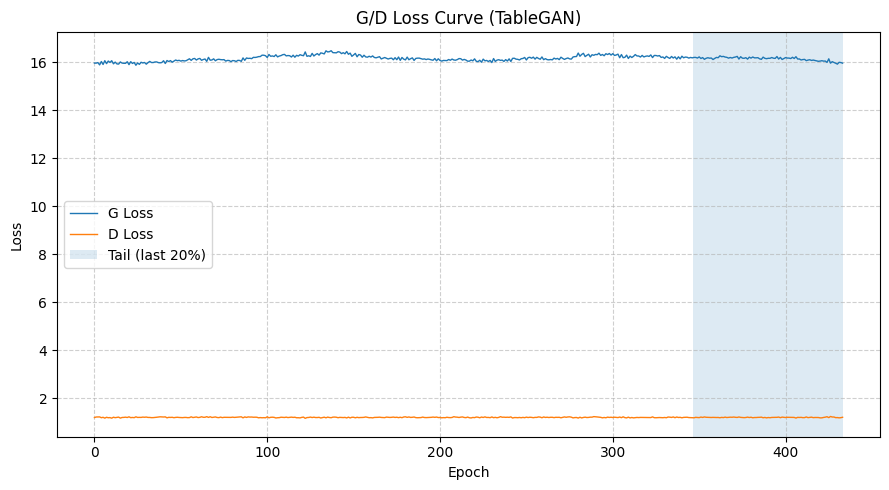

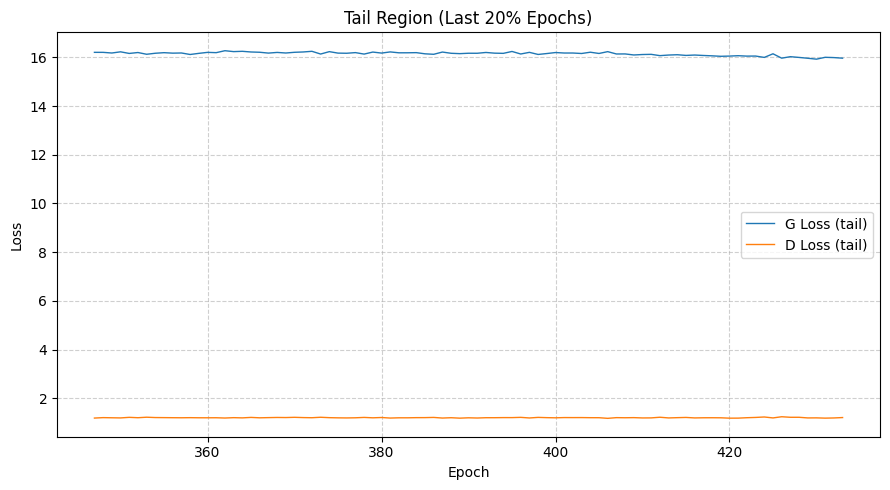

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, Tuple

# -----------------------------
# 1) 파일 로더
# -----------------------------
def load_loss_file(path: str, total_epochs: Optional[int] = None) -> pd.DataFrame:
    """
    mlruns 로깅 파일을 읽어 표준형으로 정규화.
    지원 형태:
      - 3열: [timestamp, loss, epoch]  -> epoch 사용
      - 2열: [timestamp(or step), loss] -> total_epochs로 row를 균등 매핑해 epoch 복원
      - 1열: [loss] -> total_epochs로 row를 균등 매핑해 epoch 복원
    반환: columns = ['epoch', 'loss']
    """
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")

    # 구분자 자동 추정 (공백/콤마)
    try:
        df = pd.read_csv(path, header=None, comment="#", sep=None, engine="python")
    except Exception:
        # fallback: 공백
        df = pd.read_csv(path, header=None, comment="#", delim_whitespace=True)

    ncol = df.shape[1]
    if ncol >= 3:
        # 첫 3열: timestamp, loss, epoch 로 가정
        df = df.iloc[:, :3].copy()
        df.columns = ["ts", "loss", "epoch"]
        # epoch 정수화
        df["epoch"] = df["epoch"].astype(int)
    elif ncol == 2:
        # [step(or ts), loss]
        if total_epochs is None:
            raise ValueError("epoch 컬럼이 없으므로 total_epochs 값을 지정해야 합니다.")
        df.columns = ["step", "loss"]
        # row 수를 균등 분할하여 epoch 복원
        n = len(df)
        steps_per_epoch = max(1, n // total_epochs)
        df["epoch"] = (np.arange(n) // steps_per_epoch).clip(max=total_epochs-1)
    elif ncol == 1:
        # [loss]만 있을 때
        if total_epochs is None:
            raise ValueError("단일 열(loss) 파일입니다. total_epochs 값을 지정해야 epoch를 복원할 수 있습니다.")
        df.columns = ["loss"]
        n = len(df)
        steps_per_epoch = max(1, n // total_epochs)
        df["epoch"] = (np.arange(n) // steps_per_epoch).clip(max=total_epochs-1)
    else:
        raise ValueError(f"예상치 못한 컬럼 개수: {ncol}")

    # 정리
    df = df[["epoch", "loss"]].dropna()
    return df

# -----------------------------
# 2) epoch별 평균으로 집계
# -----------------------------
def to_epoch_mean(df: pd.DataFrame, loss_col="loss") -> pd.DataFrame:
    return (df[["epoch", loss_col]]
            .groupby("epoch", as_index=False)
            .mean()
            .sort_values("epoch")
            .reset_index(drop=True))

# -----------------------------
# 3) tail 구간 & 안정성 지표
# -----------------------------
def get_tail(df_epoch: pd.DataFrame, frac: float = 0.2) -> Tuple[pd.DataFrame, float, float]:
    max_ep = int(df_epoch["epoch"].max())
    tail_start = max_ep * (1 - frac)
    tail = df_epoch[df_epoch["epoch"] >= tail_start].copy()
    return tail, float(tail_start), float(max_ep)

def drift_slope(y: np.ndarray) -> float:
    X = np.arange(len(y)).reshape(-1, 1)
    lr = LinearRegression().fit(X, y)
    return float(abs(lr.coef_[0]))

def stability_metrics_epoch(df_epoch_g: pd.DataFrame, df_epoch_d: pd.DataFrame, tail_frac=0.2):
    # epoch 기준으로 정렬/병합 (outer → 공통 구간 자동 정렬)
    df = pd.merge(df_epoch_g.rename(columns={"loss": "g_loss"}),
                  df_epoch_d.rename(columns={"loss": "d_loss"}),
                  on="epoch", how="outer").sort_values("epoch").dropna()

    tail, tail_start, max_ep = get_tail(df, frac=tail_frac)
    yg, yd = tail["g_loss"].values, tail["d_loss"].values

    return {
        "TailStartEpoch": tail_start,
        "MaxEpoch": max_ep,
        "n_tail_epochs": int(tail.shape[0]),
        "Var_G": float(np.var(yg)),
        "Var_D": float(np.var(yd)),
        "Drift_G": drift_slope(yg),
        "Drift_D": drift_slope(yd),
    }, df, tail

# -----------------------------
# 4) 사용 예시
# -----------------------------
# 파일 경로 넣기
g_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/mlruns/1/2711d95bf0b64c7f8c083ef67f8bbd26/metrics/g_loss"   # 예: g_loss.txt (공백 구분, 3열)
d_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/mlruns/1/2711d95bf0b64c7f8c083ef67f8bbd26/metrics/d_loss"   # 예: d_loss.txt

# epoch 컬럼이 없으면 total_epochs를 지정 (예: 200)
TOTAL_EPOCHS = 200

# 로드
g_raw = load_loss_file(g_path, total_epochs=TOTAL_EPOCHS)
d_raw = load_loss_file(d_path, total_epochs=TOTAL_EPOCHS)

# epoch 평균 집계
g_ep = to_epoch_mean(g_raw, "loss")
d_ep = to_epoch_mean(d_raw, "loss")

# 안정성 지표
metrics, df_all, tail = stability_metrics_epoch(g_ep, d_ep, tail_frac=0.2)
print(metrics)

# -----------------------------
# 5) (선택) 플롯: 전체 + tail 음영
# -----------------------------
plt.figure(figsize=(9,5))
plt.plot(df_all["epoch"], df_all["g_loss"], label="G Loss", linewidth=1)
plt.plot(df_all["epoch"], df_all["d_loss"], label="D Loss", linewidth=1)

plt.axvspan(metrics["TailStartEpoch"], metrics["MaxEpoch"], alpha=0.15, label="Tail (last 20%)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("G/D Loss Curve (TableGAN)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6); plt.tight_layout()
plt.show()

# (선택) tail만 확대
plt.figure(figsize=(9,5))
plt.plot(tail["epoch"], tail["g_loss"], label="G Loss (tail)", linewidth=1)
plt.plot(tail["epoch"], tail["d_loss"], label="D Loss (tail)", linewidth=1)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Tail Region (Last 20% Epochs)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6); plt.tight_layout()
plt.show()
